<strong><em>Student Academic Performance Prediction:</em></strong><br>
***
This notebook attempts to study some of the factors affecting student academic success, the first measurement of success being the GPA and the second being eligibility for application of a master's degree

Features being studied are:<br>
<t>    -> SAT score <br>
<t>    -> Athletism<br>
<t>    -> High School Size<br>
<t>    -> High School Rank<br>
<t>    -> High School Percentile<br>
<t>    -> Gender<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge , LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import statsmodels.api as sm
import dash
from dash import dcc, html, Input, Output
import plotly.express as px


In [2]:
merged_df= pd.read_csv('GPA2.csv')
unchanged_df = pd.read_csv('GPA2.csv') # for the "before" graphs

In [3]:
success =[]
successCount = 0;
failCount = 0;
for i in merged_df["gpa"]:
    if(i >= (3)):
        success.append(True)
        successCount+= 1
    else:
        success.append(False)
        failCount+=1

merged_df.insert(7,"Success", success);
print("Succes Count is: ", successCount)
print("Fail Count is: ", failCount)

Succes Count is:  1300
Fail Count is:  2835


In [4]:
merged_df

,gpa,SAT,athlete,hsize,hsrank,hsperc,female,Success
0,2.04,920,1,10,4,40.000000,1,False
1,4.00,1170,0,940,191,20.319150,0,True
2,1.78,810,1,119,42,35.294120,0,False
3,2.42,940,0,571,252,44.133100,0,False
4,2.61,1180,0,214,86,40.186920,0,False
...,...,...,...,...,...,...,...,...
4130,2.24,990,0,233,89,38.197430,1,False
4131,2.46,900,0,10,2,20.000000,1,False
4132,4.00,1340,0,45,1,2.222222,0,True
4133,2.83,980,0,35,23,65.714290,1,False


In [5]:
merged_df.describe()

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
count,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000,4135.000000
mean,2.653969,1030.324063,0.046917,279.882709,52.777993,19.229207,0.449819
std,0.656204,139.422201,0.211486,173.576713,64.636182,16.568810,0.497536
min,0.210000,470.000000,0.000000,3.000000,1.000000,0.166667,0.000000
25%,2.210000,940.000000,0.000000,164.500000,11.000000,6.430659,0.000000
50%,2.660000,1030.000000,0.000000,251.000000,30.000000,14.583330,0.000000
75%,3.120000,1120.000000,0.000000,368.000000,70.000000,27.681105,1.000000
max,4.000000,1540.000000,1.000000,940.000000,634.000000,92.000000,1.000000


In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4135 entries, 0 to 4134
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gpa      4135 non-null   float64
 1   SAT      4135 non-null   int64  
 2   athlete  4135 non-null   int64  
 3   hsize    4135 non-null   int64  
 4   hsrank   4135 non-null   int64  
 5   hsperc   4135 non-null   float64
 6   female   4135 non-null   int64  
 7   Success  4135 non-null   bool   
dtypes: bool(1), float64(2), int64(5)
memory usage: 230.3 KB


In [7]:
# we first check for duplicates:
print("merged duplicated:\n",merged_df[merged_df.duplicated()])
# we found a duplicate in the df, it's student number 533

merged duplicated:
       gpa   SAT  athlete  hsize  hsrank  hsperc  female  Success
533  3.17  1060        0     10       2    20.0       1     True


In [8]:
#idk why this messes up when we try to work on it later, someone check this plz
merged_df= merged_df.drop_duplicates()
#here we saved the merged_df without the duplicate
merged_df.info()
#we can notice that the data is now one entry less.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4134 entries, 0 to 4134
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gpa      4134 non-null   float64
 1   SAT      4134 non-null   int64  
 2   athlete  4134 non-null   int64  
 3   hsize    4134 non-null   int64  
 4   hsrank   4134 non-null   int64  
 5   hsperc   4134 non-null   float64
 6   female   4134 non-null   int64  
 7   Success  4134 non-null   bool   
dtypes: bool(1), float64(2), int64(5)
memory usage: 262.4 KB


In [9]:
# do this again after the duplicate is gone
merged_df.describe()
#we can conclude a few things from this. for example, nearly half of these students are female, 
#and almost 5% only are athletes

,gpa,SAT,athlete,hsize,hsrank,hsperc,female
count,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000,4134.000000
mean,2.653844,1030.316884,0.046928,279.947992,52.790276,19.229020,0.449686
std,0.656234,139.438302,0.211510,173.546932,64.639175,16.570810,0.497522
min,0.210000,470.000000,0.000000,3.000000,1.000000,0.166667,0.000000
25%,2.210000,940.000000,0.000000,165.000000,11.000000,6.429615,0.000000
50%,2.660000,1030.000000,0.000000,251.000000,30.000000,14.579800,0.000000
75%,3.120000,1120.000000,0.000000,368.000000,70.000000,27.686707,1.000000
max,4.000000,1540.000000,1.000000,940.000000,634.000000,92.000000,1.000000


In [10]:

# Create Dash app
app = dash.Dash(__name__)

# Define layout
app.layout = html.Div([
    html.H1("Data Visualization Dashboard"),
    html.Div([
        dcc.Dropdown(
            id='x-variable',
            options=[{'label': col, 'value': col} for col in unchanged_df.columns],
            value=unchanged_df.columns[0],  # Default value
            clearable=False,
        ),
        dcc.Dropdown(
            id='y-variable',
            options=[{'label': col, 'value': col} for col in unchanged_df.columns],
            value=unchanged_df.columns[1],  # Default value
            clearable=False,
        ),
        dcc.RadioItems(
            id='plot-type',
            options=[
                {'label': 'Scatter Plot', 'value': 'scatter'},
                {'label': 'Bar Plot', 'value': 'bar'},
                {'label': 'Line Plot', 'value': 'line'}
            ],
            value='scatter',  # Default value
            labelStyle={'display': 'block'}
        ),
    ], style={'width': '50%', 'margin': 'auto', 'textAlign': 'center'}),
    dcc.Graph(id='graph')
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input('x-variable', 'value'),
     Input('y-variable', 'value'),
     Input('plot-type', 'value')]
)
def update_graph(x_variable, y_variable, plot_type):
    if plot_type == 'scatter':
        fig = px.scatter(unchanged_df, x=x_variable, y=y_variable, title=f'{y_variable} vs {x_variable}')
    elif plot_type == 'bar':
        fig = px.bar(unchanged_df, x=x_variable, y=y_variable, title=f'{y_variable} vs {x_variable}')
    elif plot_type == 'line':
        fig = px.line(unchanged_df, x=x_variable, y=y_variable, title=f'{y_variable} vs {x_variable}')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True,port=8006)


Bins number using Rice Rule is :  64


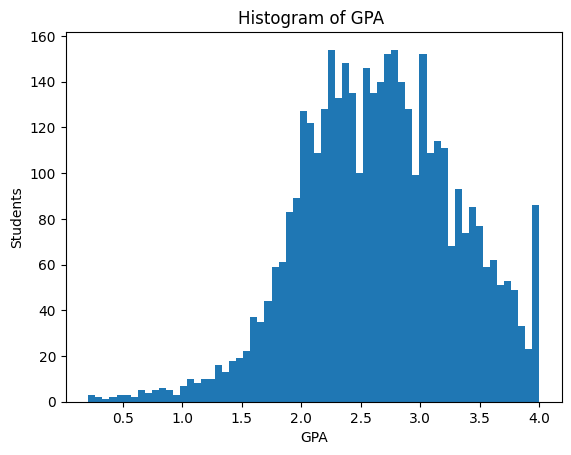

In [11]:
bin_num=2*np.cbrt(merged_df.size)
print("Bins number using Rice Rule is : ",int(bin_num))
plt.hist(merged_df['gpa'],bins=int(bin_num))
plt.xlabel('GPA')
plt.ylabel('Students')
plt.title('Histogram of GPA ')
plt.show()


<Figure size 1200x800 with 0 Axes>

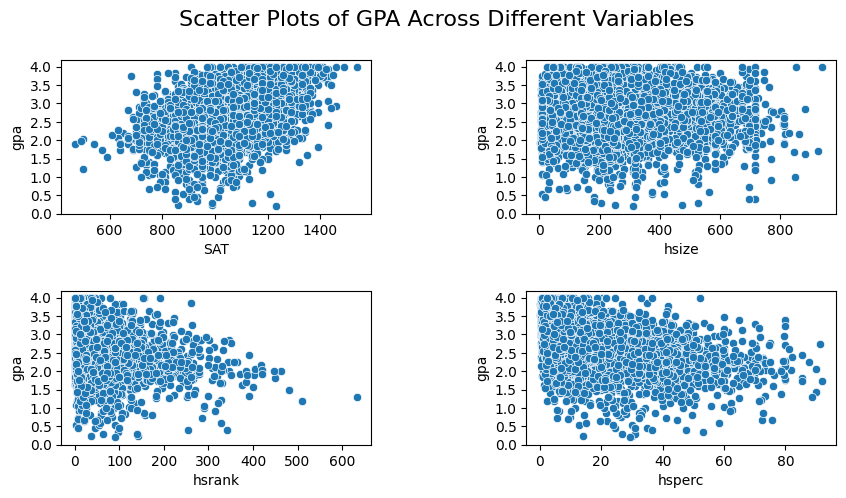

In [12]:
plt.figure(figsize=(12, 8))
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5,hspace=0.5)
# subplots of gpa with each numerical variable
sns.scatterplot(x='SAT', y='gpa', data=merged_df,ax=axes[0,0])
sns.scatterplot(x='hsize', y='gpa', data=merged_df,ax=axes[0,1])
sns.scatterplot(x='hsrank', y='gpa', data=merged_df,ax=axes[1,0])
sns.scatterplot(x='hsperc', y='gpa', data=merged_df,ax=axes[1,1])
yticks = np.arange(0, 4.5, 0.5) #to show gpa with steps of 0.5
for ax in axes.flatten():
    ax.set_yticks(yticks)
fig.suptitle('Scatter Plots of GPA Across Different Variables', fontsize=16)
plt.show()

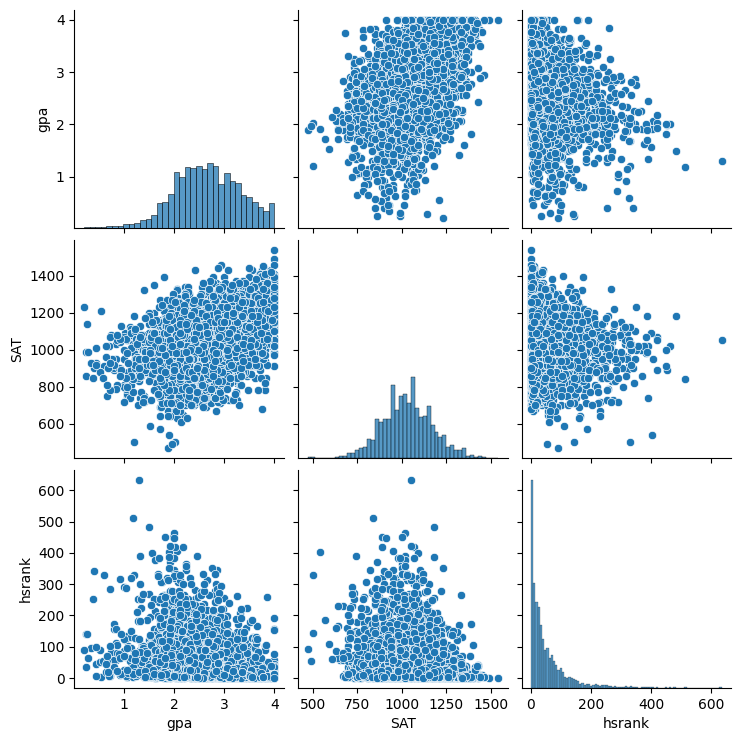

In [13]:
#this looks cool ig?
sns.pairplot(merged_df[['gpa', 'SAT', 'hsrank']])
plt.show()

<Figure size 1200x800 with 0 Axes>

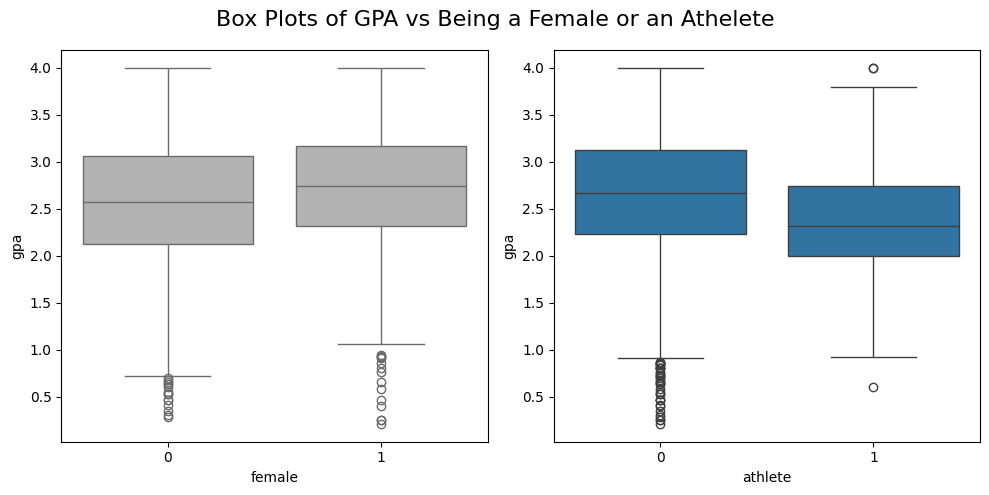

In [14]:
plt.figure(figsize=(12, 8))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
sns.boxplot(x='female', y='gpa', data=merged_df,ax=axes[0], color = (0.7,0.7,0.7))
sns.boxplot(x='athlete', y='gpa' , data=merged_df,ax=axes[1])
fig.suptitle('Box Plots of GPA vs Being a Female or an Athelete', fontsize=16)
plt.tight_layout()
plt.show()


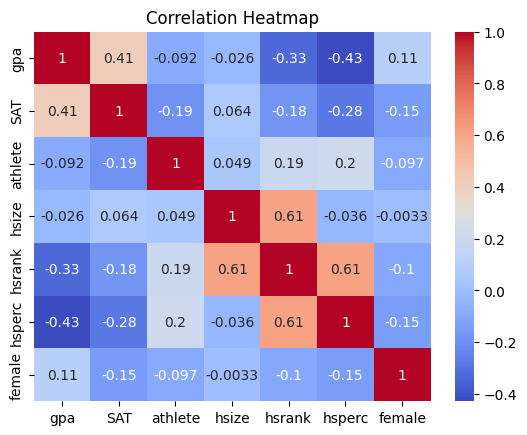

In [15]:
# Generate the correlation matrix
correlation_matrix = merged_df[['gpa', 'SAT', 'athlete','hsize','hsrank','hsperc','female']].corr()

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


***
<strong><em>Initial Test Using All of The Dataset:</em></strong><br>
***

In [16]:
# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

In [17]:
#Normal LinearRegression with k = 3 fold cross validation

best_mse = 17 #arbitrarly large MSE, (MSE for 0% accuracy is at maximum 16)
best_model = 0


kf = KFold(n_splits=3, random_state=None)
total_test_mse = 0
total_train_mse = 0
    
for j, (train_index, test_index) in enumerate(kf.split(X)):

    # Train Test split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)


    X_train_norm = (X_train - mean_X_train)/std_X_train
    X_test_norm = (X_test - mean_X_train)/std_X_train

    y_train_norm = (y_train - mean_y_train)/std_y_train
    y_test_norm = (y_test - mean_y_train)/std_y_train

    # Linear Regression
    model = LinearRegression(fit_intercept= True)
    model.fit(X_train_norm, y_train_norm)

    # Train and test MSE
    y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
    y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

    train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
    test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
    total_train_mse += train_mse
    total_test_mse += test_mse

    if (test_mse < best_mse): #Choose the model with lowest MSE for hypothesis testing and R2 Calculation
        best_mse = test_mse
        best_model = model

print("Average Train MSE:", total_train_mse / kf.get_n_splits())
print("Average Test MSE:", total_test_mse / kf.get_n_splits())


Average Train MSE: 0.30159914708783625
Average Test MSE: 0.3083517557563017


In [18]:
#ٌR2 Score Calculation

X_all_norm = (X - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

The r2 score is:  0.295018327885364


In [19]:
#Hypothesis testing on the least error model

X_const_added = sm.add_constant(X_all_norm)
est = sm.OLS(y,X_all_norm)
est2 = est.fit()
print(est2.summary())


                                 OLS Regression Results                                
Dep. Variable:                    gpa   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):              0.021
Method:                 Least Squares   F-statistic:                              15.52
Date:                Sat, 18 May 2024   Prob (F-statistic):                    1.10e-17
Time:                        05:44:51   Log-Likelihood:                         -9977.3
No. Observations:                4134   AIC:                                  1.997e+04
Df Residuals:                    4128   BIC:                                  2.000e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

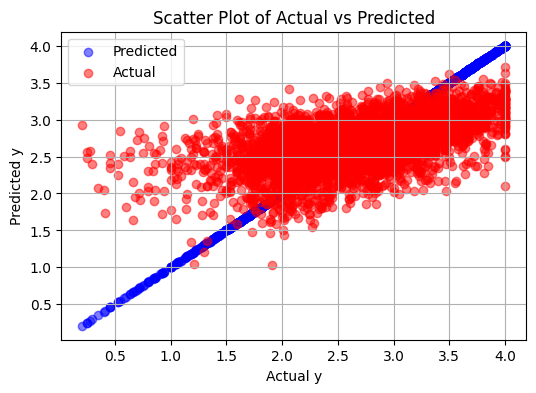

In [20]:
#Plotting a sample of 500 students


numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y, y, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y, y_pred_all_unnormalized, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
best_mse = 10
best_model = 0

alphas = [0, 0.1,0.5, 1,10,100]

for i, alpha in enumerate(alphas):

    kf = KFold(n_splits=3, random_state=None)
    total_test_mse = 0
    total_train_mse = 0
        
    for j, (train_index, test_index) in enumerate(kf.split(X)):

        # Train Test split
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        # Normalization
        mean_X_train = np.mean(X_train, axis=0)
        std_X_train = np.std(X_train, axis=0)
        mean_y_train = np.mean(y_train)
        std_y_train = np.std(y_train)


        X_train_norm = (X_train - mean_X_train)/std_X_train
        X_test_norm = (X_test - mean_X_train)/std_X_train

        y_train_norm = (y_train - mean_y_train)/std_y_train
        y_test_norm = (y_test - mean_y_train)/std_y_train

        # Ridge Regression
        model = Ridge(alpha = alpha)
        model.fit(X_train_norm, y_train_norm)

        # Train and test MSE
        y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
        y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

        train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
        test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
        total_train_mse += train_mse
        total_test_mse += test_mse

        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model

    print("Average Train MSE:", total_train_mse / kf.get_n_splits())
    print("Average Test MSE:", total_test_mse / kf.get_n_splits())
    print()


Average Train MSE: 0.3015991470878362
Average Test MSE: 0.3083517557563017

Average Train MSE: 0.3015991471984911
Average Test MSE: 0.3083516926380937

Average Train MSE: 0.30159914985299513
Average Test MSE: 0.3083514431159216

Average Train MSE: 0.3015991581424142
Average Test MSE: 0.3083511378411292

Average Train MSE: 0.30160024184023654
Average Test MSE: 0.30834688190356646

Average Train MSE: 0.30169949154763853
Average Test MSE: 0.30841626770306996



In [22]:
X_all_norm = (X - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

The r2 score is:  0.29442610632053745


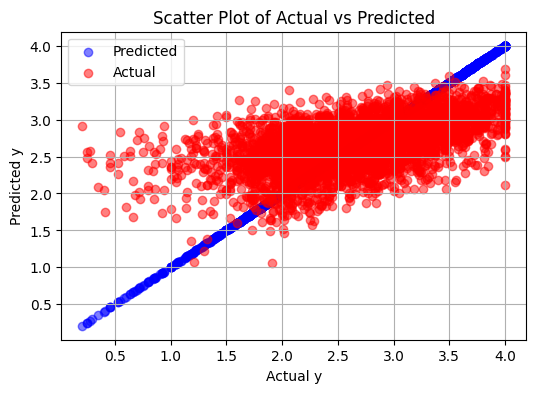

In [23]:
import matplotlib.pyplot as plt

numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y, y, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y, y_pred_all_unnormalized, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
best_model = 0
best_mse = 10

# Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)


X_train_norm = (X_train - mean_X_train)/std_X_train
X_test_norm = (X_test - mean_X_train)/std_X_train


y_train_norm = (y_train - mean_y_train)/std_y_train
y_test_norm = (y_test - mean_y_train)/std_y_train

degrees = [1,2,4,8]
alphas = [0.1,0.5,1,5,10]
for deg in degrees:

    # Polynomial Features
    poly = PolynomialFeatures(degree=deg, include_bias= True)  # You can adjust the degree as needed
    X_poly_train_norm = poly.fit_transform(X_train_norm)

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train_norm, y_train_norm)

        X_poly_test_norm = poly.fit_transform(X_test_norm)


        train_mse = mean_squared_error(y_train, (model.predict(X_poly_train_norm)*std_y_train)+mean_y_train)
        test_mse = mean_squared_error(y_test, (model.predict(X_poly_test_norm)*std_y_train)+mean_y_train)
        
        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model
            best_poly = poly

c:\Users\Rio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning:

Ill-conditioned matrix (rcond=3.2041e-18): result may not be accurate.

c:\Users\Rio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning:

Ill-conditioned matrix (rcond=1.61646e-17): result may not be accurate.

c:\Users\Rio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning:

Ill-conditioned matrix (rcond=1.91497e-17): result may not be accurate.



The r2 score is:  0.31718853135697567


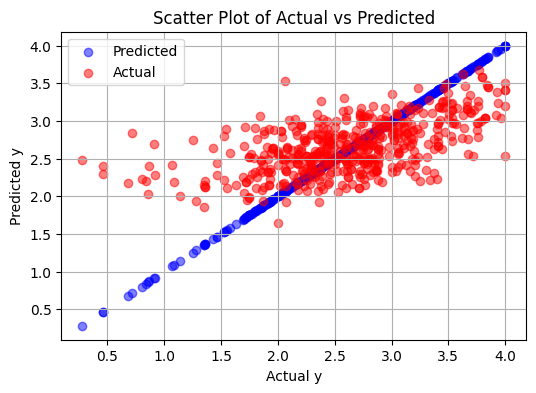

The r2 score is:  0.31718853135697567


In [25]:
X_norm = (X - mean_X_train)/std_X_train
X_poly = best_poly.fit_transform(X_norm)
y_pred_all_unnormalized = (best_model.predict(X_poly)*std_y_train)+mean_y_train

print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))

numss = [np.random.randint(1,len(y)) for _ in range(500)]
y_rand = y.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()
print ("The r2 score is: ", r2_score(y,y_pred_all_unnormalized))


REMOVING OUTLIERS

In [26]:
change = 25

first_quartile = np.percentile(y, change)
fourth_quartile = np.percentile(y, 100-change)

iqr = fourth_quartile - first_quartile

lower_bound = first_quartile - 1.5 * iqr
upper_bound = fourth_quartile + 1.5 * iqr

outlier_indices = np.where((y < lower_bound) | (y > upper_bound))[0]

merged_df_no_OUT = merged_df[(merged_df['gpa'] > lower_bound) & (merged_df['gpa'] < upper_bound)]


X_no_outliers = merged_df_no_OUT[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y_no_outliers = merged_df_no_OUT['gpa']


In [27]:
best_mse = 10
best_model = 0


kf = KFold(n_splits=3, random_state=None)
total_test_mse = 0
total_train_mse = 0
    
for j, (train_index, test_index) in enumerate(kf.split(X_no_outliers)):

    # Train Test split
    X_train, X_test = X_no_outliers.iloc[train_index], X_no_outliers.iloc[test_index]
    y_train, y_test = y_no_outliers.iloc[train_index], y_no_outliers.iloc[test_index]


    # Normalization
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)


    X_train_norm = (X_train - mean_X_train)/std_X_train
    X_test_norm = (X_test - mean_X_train)/std_X_train

    y_train_norm = (y_train - mean_y_train)/std_y_train
    y_test_norm = (y_test - mean_y_train)/std_y_train

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train_norm, y_train_norm)

    # Train and test MSE
    y_train_predict_unnormalized = (model.predict(X_train_norm) * std_y_train) + mean_y_train
    y_test_predict_unnormalized = (model.predict(X_test_norm) * std_y_train) + mean_y_train

    train_mse = np.mean((y_train_predict_unnormalized - y_train) ** 2)
    test_mse = np.mean((y_test_predict_unnormalized - y_test) ** 2)
    total_train_mse += train_mse
    total_test_mse += test_mse

    if (test_mse < best_mse):
        best_mse = test_mse
        best_model = model

print("Average Train MSE:", total_train_mse / kf.get_n_splits())
print("Average Test MSE:", total_test_mse / kf.get_n_splits())


Average Train MSE: 0.27882171398083905
Average Test MSE: 0.2845323214598053


In [28]:
X_all_norm = (X_no_outliers - mean_X_train)/std_X_train
y_pred_all = best_model.predict(X_all_norm)
y_pred_all_unnormalized = (y_pred_all * std_y_train) + mean_y_train

print ("The r2 score is: ", r2_score(y_no_outliers,y_pred_all_unnormalized))

The r2 score is:  0.2979862177884639


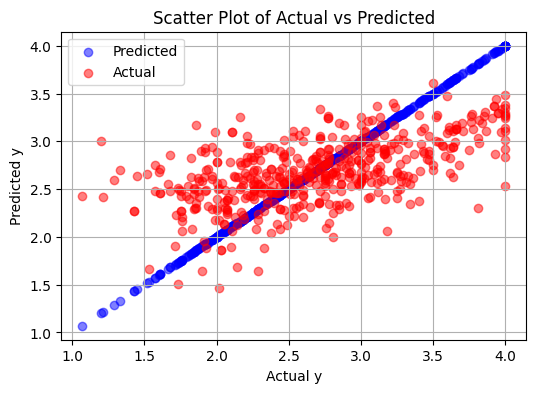

In [29]:
numss = [np.random.randint(1,len(y_no_outliers)) for _ in range(500)]
y_rand = y_no_outliers.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=50)
best_model = 0
best_mse = 10

# Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)


X_train_norm = (X_train - mean_X_train)/std_X_train
X_test_norm = (X_test - mean_X_train)/std_X_train


y_train_norm = (y_train - mean_y_train)/std_y_train
y_test_norm = (y_test - mean_y_train)/std_y_train

degrees = [1,2,4,8]
alphas = [0.1,0.5,1,5,10]
for deg in degrees:

    # Polynomial Features
    poly = PolynomialFeatures(degree=deg, include_bias= True)  # You can adjust the degree as needed
    X_poly_train_norm = poly.fit_transform(X_train_norm)

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train_norm, y_train_norm)

        X_poly_test_norm = poly.fit_transform(X_test_norm)


        train_mse = mean_squared_error(y_train, (model.predict(X_poly_train_norm)*std_y_train)+mean_y_train)
        test_mse = mean_squared_error(y_test, (model.predict(X_poly_test_norm)*std_y_train)+mean_y_train)
        
        if (test_mse < best_mse):
            best_mse = test_mse
            best_model = model
            best_poly = poly

c:\Users\Rio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning:

Ill-conditioned matrix (rcond=3.36816e-18): result may not be accurate.

c:\Users\Rio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning:

Ill-conditioned matrix (rcond=1.67951e-17): result may not be accurate.

c:\Users\Rio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning:

Ill-conditioned matrix (rcond=3.35387e-17): result may not be accurate.



In [31]:
X_norm = (X_no_outliers - mean_X_train)/std_X_train
X_poly = best_poly.fit_transform(X_norm)
y_pred_all_unnormalized = (best_model.predict(X_poly)*std_y_train)+mean_y_train

print ("The r2 score is: ", r2_score(y_no_outliers,y_pred_all_unnormalized))


The r2 score is:  0.32130075720068174


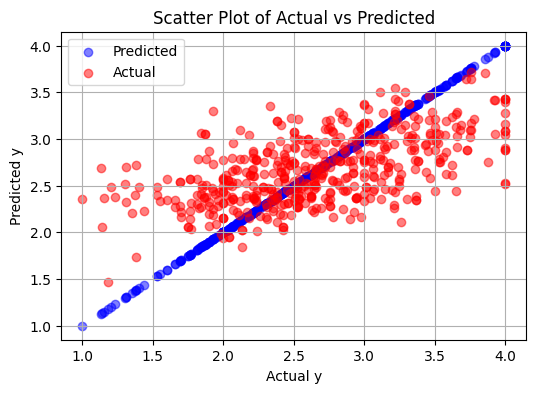

In [32]:
numss = [np.random.randint(1,len(y_no_outliers)) for _ in range(500)]
y_rand = y_no_outliers.iloc[numss]
y_pred_rand = y_pred_all_unnormalized[numss]

# Assuming y_pred_all_unnormalized and y are numpy arrays of the same length
plt.figure(figsize=(6, 4))
plt.scatter(y_rand, y_rand, color='blue', label='Predicted', alpha=0.5)
plt.scatter(y_rand, y_pred_rand, color='red', label='Actual', alpha=0.5)  # Actual values
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Scatter Plot of Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

Following commented code got cleaned in the above.


In [33]:
""" XColumns = ['SAT', 'athlete','hsize','hsrank','hsperc','female']

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']


# Try a different random seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

mean_X = np.mean(X_train, axis=0)
std_X = np.std(X_train, axis=0)
mean_y = np.mean(y_train)
std_y = np.std(y_train)
X_train_norm = (X_train - mean_X) / std_X
y_train_norm = (y_train - mean_y) / std_y """

" XColumns = ['SAT', 'athlete','hsize','hsrank','hsperc','female']\n\n# Split data\nX = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]\ny = merged_df['gpa']\n\n\n# Try a different random seed\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)\n\nmean_X = np.mean(X_train, axis=0)\nstd_X = np.std(X_train, axis=0)\nmean_y = np.mean(y_train)\nstd_y = np.std(y_train)\nX_train_norm = (X_train - mean_X) / std_X\ny_train_norm = (y_train - mean_y) / std_y "

In [34]:
""" # Train model
model = LinearRegression()
model.fit(X_train_norm, y_train_norm)

listCoeff = model.coef_

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred))) """


' # Train model\nmodel = LinearRegression()\nmodel.fit(X_train_norm, y_train_norm)\n\nlistCoeff = model.coef_\n\n# Cross-validation\ncv_scores = cross_val_score(model, X, y, cv=5, scoring=\'neg_mean_squared_error\')\ncv_rmse = np.sqrt(-cv_scores)\nprint("Cross-validation RMSE scores:", cv_rmse)\nprint("Mean CV RMSE:", np.mean(cv_rmse))\n\n# Predict and evaluate\ny_train_pred = model.predict(X_train)\ny_test_pred = model.predict(X_test)\n\nprint("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))\nprint("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred))) '

In [35]:
""" 
N = len(X)
p = len(X.columns) + 1  # plus one because LinearRegression adds an intercept term
X_with_intercept = np.empty(shape=(N, p), dtype=float)
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = X.values
beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values
print(beta_hat)

y_hat = model.predict(X)
residuals = (y.values) - (y_hat)
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (N - p)
var_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat
for p_ in range(p):
    standard_error = var_beta_hat[p_, p_] ** 0.5
    print(f"SE(beta_hat[{p_}]): {standard_error}")


print ("The r2 score is: ", r2_score(y,y_hat)) """

' \nN = len(X)\np = len(X.columns) + 1  # plus one because LinearRegression adds an intercept term\nX_with_intercept = np.empty(shape=(N, p), dtype=float)\nX_with_intercept[:, 0] = 1\nX_with_intercept[:, 1:p] = X.values\nbeta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y.values\nprint(beta_hat)\n\ny_hat = model.predict(X)\nresiduals = (y.values) - (y_hat)\nresidual_sum_of_squares = residuals.T @ residuals\nsigma_squared_hat = residual_sum_of_squares / (N - p)\nvar_beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) * sigma_squared_hat\nfor p_ in range(p):\n    standard_error = var_beta_hat[p_, p_] ** 0.5\n    print(f"SE(beta_hat[{p_}]): {standard_error}")\n\n\nprint ("The r2 score is: ", r2_score(y,y_hat)) '

In [36]:
""" from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']  # Assuming 'gpa' is the continuous variable to predict

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
 """

' from sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.tree import DecisionTreeRegressor\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\n# Split data\nX = merged_df[[\'SAT\', \'athlete\',\'hsize\',\'hsrank\',\'hsperc\',\'female\']]\ny = merged_df[\'gpa\']  # Assuming \'gpa\' is the continuous variable to predict\n\n# Train-test split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)\n\n# Train model\nmodel = DecisionTreeRegressor()\nmodel.fit(X_train, y_train)\n\n# Cross-validation\ncv_scores = cross_val_score(model, X, y, cv=5, scoring=\'neg_mean_squared_error\')\ncv_rmse = np.sqrt(-cv_scores)\nprint("Cross-validation RMSE scores:", cv_rmse)\nprint("Mean CV RMSE:", np.mean(cv_rmse))\n\n# Predict and evaluate\ny_train_pred = model.predict(X_train)\ny_test_pred = model.predict(X_test)\n\nprint("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))\nprint("Test RMSE:", np.sqrt(mean

In [37]:
""" from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
 """

' from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\n# Split data\nX = merged_df[[\'SAT\', \'athlete\',\'hsize\',\'hsrank\',\'hsperc\',\'female\']]\ny = merged_df[\'gpa\']\n\n# Train-test split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)\n\n# Train model\nmodel = RandomForestRegressor()\nmodel.fit(X_train, y_train)\n\n# Cross-validation\ncv_scores = cross_val_score(model, X, y, cv=5, scoring=\'neg_mean_squared_error\')\ncv_rmse = np.sqrt(-cv_scores)\nprint("Cross-validation RMSE scores:", cv_rmse)\nprint("Mean CV RMSE:", np.mean(cv_rmse))\n\n# Predict and evaluate\ny_train_pred = model.predict(X_train)\ny_test_pred = model.predict(X_test)\n\nprint("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))\nprint("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))\n '

In [38]:
""" from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# Split data
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['gpa']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Train model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE:", np.mean(cv_rmse))

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
 """

' from sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.metrics import mean_squared_error\nimport numpy as np\n\n# Split data\nX = merged_df[[\'SAT\', \'athlete\',\'hsize\',\'hsrank\',\'hsperc\',\'female\']]\ny = merged_df[\'gpa\']\n\n# Train-test split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)\n\n# Train model\nmodel = GradientBoostingRegressor()\nmodel.fit(X_train, y_train)\n\n# Cross-validation\ncv_scores = cross_val_score(model, X, y, cv=5, scoring=\'neg_mean_squared_error\')\ncv_rmse = np.sqrt(-cv_scores)\nprint("Cross-validation RMSE scores:", cv_rmse)\nprint("Mean CV RMSE:", np.mean(cv_rmse))\n\n# Predict and evaluate\ny_train_pred = model.predict(X_train)\ny_test_pred = model.predict(X_test)\n\nprint("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))\nprint("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))\n '

HERE STARTS CLASSIFICATION CODE CLEANING


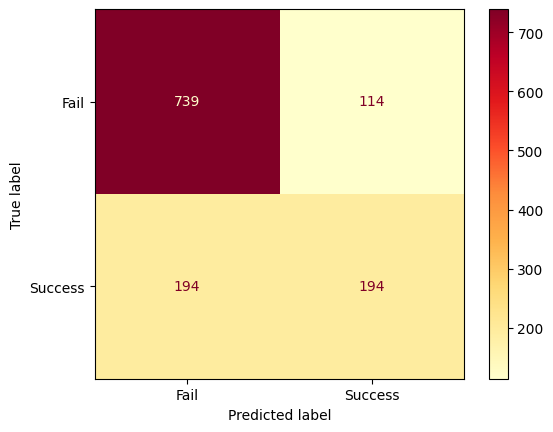

0.7518130539887188


In [39]:
X = merged_df[['SAT', 'athlete','hsize','hsrank','hsperc','female']]
y = merged_df['Success']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
model = KNeighborsClassifier(n_neighbors= 5)

#Normalization
mean_X_train = np.mean(X_train, axis=0)
std_X_train = np.std(X_train, axis=0)


X_train_norm = (X_train-mean_X_train)/std_X_train


model.fit(X_train_norm,y_train)

X_test_norm = (X_test - mean_X_train)/ std_X_train


y_pred = model.predict(X_test_norm)

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
cm_display.plot(cmap = "YlOrRd")
plt.show()

print(model.score(X_test_norm, y_test))

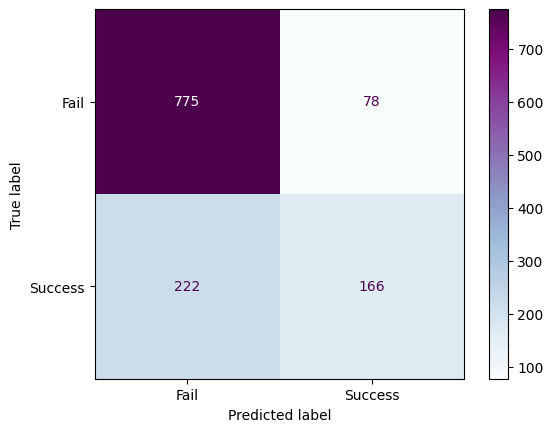

0.75825946817083


In [40]:



model = LogisticRegression(random_state=0,C=0.01,fit_intercept=True)
model.fit(X_train_norm, y_train)

y_pred = model.predict(X_test_norm)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
cm_display.plot(cmap = "BuPu")
plt.show()

print(model.score(X_test_norm, y_test))

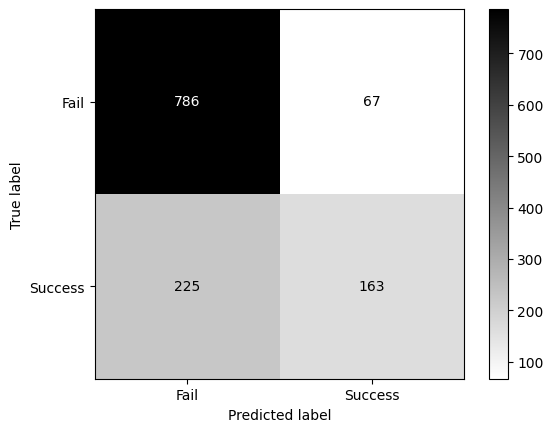

0.7647058823529411


In [41]:


model = SVC(kernel='rbf', probability=True)
model.fit(X_train_norm, y_train)

y_pred = model.predict(X_test_norm)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Fail", "Success"],)
cm_display.plot(cmap = "binary")
plt.show()

print(model.score(X_test_norm, y_test))





1. Coorelation testing - Heatmaps, pair plots, hypothesis testing,  qq plot 
2. EDA
3. EDA models 
4. Report 

5 (Extra). Understand models extensively
